指令微调扩展实验1：微调训练的时候增加PAD Token Mask, 对PAD Token不做注意力计算

> 实验结果：没任何影响。

原因，问了下Gemini3-Pro：

我在训练GPT2模型的时候，发现在多头注意力计算模块中，应用padding mask和不应用padding mask没区别，这是为何呢？

---  

这是一个非常深刻且在实际训练中容易被忽视的问题。如果你发现在训练 GPT-2（或类似的 Causal Decoder-only 模型）时，应用 Padding Mask（填充掩码）和不应用它似乎没有区别，通常是由以下几个核心原因造成的。

为了深入理解这个问题，我们需要先回顾 GPT-2 的注意力机制和掩码的工作原理。

### 核心背景：两种掩码的区别

在 GPT-2 这种 Decoder-only 的架构中，主要涉及两种掩码：

1.  **Causal Mask (Look-ahead Mask / Triangular Mask):**
    *   **作用：** 防止模型“偷看”未来的 Token。位置 $i$ 只能看到位置 $0$ 到 $i$ 的信息。
    *   **形状：** 一个下三角矩阵（对角线及以下为 1，上方为 0 或负无穷）。
    *   **必要性：** **绝对必须**。没有它，模型就变成了双向的（像 BERT），无法进行自回归生成。

2.  **Padding Mask (Key Padding Mask):**
    *   **作用：** 告诉模型哪些 Token 是填充的（`<pad>`），不应该参与计算注意力分数。
    *   **形状：** 通常是一个布尔矩阵，标记哪些位置是有效的，哪些是 Padding。
    *   **必要性：** 理论上需要，但在 GPT 类模型中，**其重要性往往被高估或被 Causal Mask 隐式处理了**。

---

### 原因分析：为何 Padding Mask 看起来没区别？

以下是导致这一现象的四个主要原因，按可能性从高到低排列：

#### 1. Causal Mask 的“屏蔽”效应 (最常见原因)

这是最根本的原因。在 GPT-2 的自注意力机制中，**Causal Mask 已经限制了 Token 只能关注它左边的内容**。

*   **场景：** 假设你的 Batch 数据如下（`P` 代表 Padding）：
    `[A, B, C, P, P]`
*   **对于有效 Token (A, B, C)：**
    *   A 只能看 A。
    *   B 只能看 A, B。
    *   C 只能看 A, B, C。
    *   **关键点：** 有效的 Token (A, B, C) **永远在 Padding (P) 的左边**（如果我们使用右侧填充）。由于 Causal Mask 的存在，A、B、C 根本就没有机会去“看”右边的 P。
*   **结论：** 只要你使用的是**右侧填充 (Right Padding)**，对于所有非 Padding 的有效 Token 来说，Padding Mask 是完全多余的，因为 Causal Mask 已经把右边的 Padding 挡住了。

#### 2. Padding Token 的 Loss 被忽略了

在计算最终的 Loss（通常是 CrossEntropyLoss）时，我们通常会设置 `ignore_index`。

*   **计算过程：**
    1.  模型计算所有位置的输出（包括 Padding 位置）。
    2.  虽然 Padding 位置可能会因为没有 Padding Mask 而去关注前面的有效 Token，从而产生非零的输出向量。
    3.  **但是**，在计算 Loss 时，我们通常设置 `loss_fct = CrossEntropyLoss(ignore_index=pad_token_id)`。
    4.  这意味着，虽然 Padding 位置计算出了“错误的”或“无意义的”注意力，但这些位置产生的预测结果**根本不参与梯度的反向传播**。
*   **结论：** 既然 Padding 位置的输出不影响 Loss，那么它们是否正确地 mask 掉前面的信息也就无关紧要了。

#### 3. 注意力分数的 Softmax 特性

即使在极少数情况下（例如左侧填充，或者 Padding 在中间），Padding Mask 没有加上，Softmax 也会起到一定的平滑作用。

*   如果 Padding Token 的 Embedding 向量是随机初始化的，它们与 Query 的点积可能很小。
*   经过 Softmax 后，分配给 Padding 的权重可能本身就很低（虽然不是严格的 0）。这会稀释影响，使得模型看起来依然在收敛，虽然性能可能会受到微小的、难以察觉的负面影响。

#### 4. 数据预处理方式 (Packing / Concatenation)

很多现代 LLM 训练（如 LLaMA 训练流程）为了提高效率，不再使用传统的 Padding。

*   **做法：** 将多条短文本拼接（Concat）在一起，中间用 `<eos>` 分隔，直到填满 `max_seq_len`。
*   **结果：** 这种情况下，Batch 中几乎没有 Padding Token（或者极少）。
*   **结论：** 如果你的数据处理逻辑是这样的，那么 Padding Mask 自然就没有存在的意义，因为根本没有 Padding。

---

### 什么时候 Padding Mask 是必须的？

虽然在标准的 GPT-2 右侧填充训练中它看起来没用，但在以下情况中它是**必须**的：

1.  **左侧填充 (Left Padding)：**
    *   通常用于推理（Generation）阶段。如果你的 Batch 是 `[P, P, A, B, C]`，那么 A 在计算注意力时，如果不加 Mask，就会看到左边的 P。这会干扰 A 的特征表示。
2.  **双向模型 (BERT/Encoder)：**
    *   BERT 允许看上下文，如果不 Mask 掉 Padding，模型会利用 Padding 的信息，导致严重错误。
3.  **Cross-Attention (Encoder-Decoder 架构)：**
    *   在 Transformer 的 Decoder 中，Cross-Attention 模块关注 Encoder 的输出。这时必须把 Encoder 输出中的 Padding Mask 掉，否则 Decoder 会关注到 Encoder 的废弃部分。

### 总结与建议

**结论：**
如果在训练 GPT-2 时使用的是**右侧填充 (Right Padding)** 并且正确设置了 Loss 函数的 **`ignore_index`**，那么**不应用 Padding Mask 对训练结果确实没有影响**。这是因为 Causal Mask 已经阻止了有效 Token 看到右侧的 Padding，而 Loss 计算又忽略了 Padding 位置本身的输出。

**建议：**
尽管如此，为了代码的健壮性和兼容性（防止未来切换到左侧填充或修改架构），**最佳实践依然是加上 Padding Mask**。

In [73]:
import torch
import numpy as np
import torch.nn as nn


MODEL_CONFIG= {
    'vocab_size': 50257,
    'context_length': 1024,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.scale = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return self.scale * (x - mean) / torch.sqrt(var + self.eps) + self.shift

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, n_heads, context_length, drop_rate, qkv_bias=False):
        super().__init__()
        assert emb_dim % n_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())
        self.W_q = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_k = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_v = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_o = nn.Linear(emb_dim, emb_dim)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x, padding_mask=None): # padding_mask shape: (B,L)
        batch_size, seq_len, dim = x.shape
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        # 拆多头
        queries = queries.view(batch_size, seq_len, self.n_heads, self.head_dim)
        keys = keys.view(batch_size, seq_len, self.n_heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.n_heads, self.head_dim)
        # 调整位置
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        # 计算注意力分数
        att_scores = queries @ keys.transpose(-2, -1) / keys.shape[-1] ** 0.5
        att_scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf)
        if padding_mask is not None:
            padding_mask = padding_mask.view(batch_size, 1, 1, -1)
            att_scores.masked_fill_(padding_mask, -torch.inf)
        att_weights = torch.softmax(att_scores, dim=-1)
        att_weights = self.dropout(att_weights)
        context_vec = att_weights @ values # shape (B,H,L,D)
        # 头调整回去
        context_vec = context_vec.transpose(1,2).contiguous().view(batch_size, seq_len, dim)
        out = self.W_o(context_vec)
        return out
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, emb_dim * 4)
        self.fc2 = nn.Linear(emb_dim * 4, emb_dim)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.att = MultiHeadAttention(cfg['emb_dim'], cfg['n_heads'], cfg['context_length'], cfg['drop_rate'], cfg['qkv_bias'])
        self.ff = FeedForward(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, inputs):
        x, padding_mask = inputs
        residual = x
        x = self.norm1(x)
        x = self.att(x, padding_mask)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + residual
        return (x, padding_mask)

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, input_ids, pad_token_id=50256):
        batch_size, seq_len = input_ids.shape
        padding_mask = input_ids == pad_token_id
        tok_embed = self.tok_emb(input_ids)
        pos_embed = self.pos_emb(torch.arange(seq_len, device=input_ids.device))
        x = tok_embed + pos_embed
        x = self.drop_emb(x)
        x,_ = self.trf_blocks((x, padding_mask))
        x = self.final_norm(x)
        loggits = self.out_head(x)
        return loggits

In [21]:
test_tokenids = torch.tensor([[1,2,3,4,5,6,-100,-100]])
print(test_tokenids)
test_tokenids_mask = test_tokenids == -100
print(test_tokenids_mask)

tensor([[   1,    2,    3,    4,    5,    6, -100, -100]])
tensor([[False, False, False, False, False, False,  True,  True]])


In [16]:
torch.triu(torch.ones(10, 10), diagonal=1)

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
torch.triu(torch.ones(10, 10), diagonal=2)

tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [23]:
torch.rand(8,8).masked_fill_(torch.triu(torch.ones(8, 8), diagonal=1).bool(), -torch.inf)

tensor([[0.2315,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.8956, 0.9594,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.3896, 0.6360, 0.3435,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4110, 0.2196, 0.2884, 0.7004,   -inf,   -inf,   -inf,   -inf],
        [0.0831, 0.6955, 0.4569, 0.5083, 0.5049,   -inf,   -inf,   -inf],
        [0.3639, 0.3376, 0.5094, 0.5533, 0.0158, 0.9663,   -inf,   -inf],
        [0.6063, 0.8651, 0.7173, 0.8124, 0.3056, 0.8466, 0.0579,   -inf],
        [0.0011, 0.8377, 0.6703, 0.7992, 0.4780, 0.8317, 0.8205, 0.7092]])

In [25]:
# 先不考虑批次维度，先看下如何将padding mask也加入到att scores中
att_scores = torch.rand(8,8).masked_fill_(torch.triu(torch.ones(8, 8), diagonal=1).bool(), -torch.inf)
print(att_scores)
test_tokenids = torch.tensor([1,2,3,4,5,6,-100,-100])
test_tokenids_mask = test_tokenids == -100
print(test_tokenids_mask)
att_scores.masked_fill_(test_tokenids_mask, -torch.inf)
print(att_scores)

tensor([[0.0468,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5085, 0.8450,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5393, 0.9506, 0.5013,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1254, 0.0291, 0.1227, 0.0293,   -inf,   -inf,   -inf,   -inf],
        [0.4296, 0.5999, 0.7586, 0.8983, 0.9573,   -inf,   -inf,   -inf],
        [0.5348, 0.1726, 0.3836, 0.9099, 0.7770, 0.1242,   -inf,   -inf],
        [0.1058, 0.7375, 0.8985, 0.0397, 0.1927, 0.7766, 0.3893,   -inf],
        [0.9766, 0.5614, 0.0111, 0.8473, 0.4994, 0.7738, 0.8179, 0.8941]])
tensor([False, False, False, False, False, False,  True,  True])
tensor([[0.0468,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5085, 0.8450,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.5393, 0.9506, 0.5013,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1254, 0.0291, 0.1227, 0.0293,   -inf,   -inf,   -inf,   -inf],
        [0.4296, 0.5999, 0.7586, 0.8983, 0.957

In [27]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt:GPTModel, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.weight = assign(
            gpt.trf_blocks[b].att.W_q.weight, q_w.T)
        gpt.trf_blocks[b].att.W_k.weight = assign(
            gpt.trf_blocks[b].att.W_k.weight, k_w.T)
        gpt.trf_blocks[b].att.W_v.weight = assign(
            gpt.trf_blocks[b].att.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.bias = assign(
            gpt.trf_blocks[b].att.W_q.bias, q_b)
        gpt.trf_blocks[b].att.W_k.bias = assign(
            gpt.trf_blocks[b].att.W_k.bias, k_b)
        gpt.trf_blocks[b].att.W_v.bias = assign(
            gpt.trf_blocks[b].att.W_v.bias, v_b)

        gpt.trf_blocks[b].att.W_o.weight = assign(
            gpt.trf_blocks[b].att.W_o.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.W_o.bias = assign(
            gpt.trf_blocks[b].att.W_o.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.fc1.weight = assign(
            gpt.trf_blocks[b].ff.fc1.weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.fc1.bias = assign(
            gpt.trf_blocks[b].ff.fc1.bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.fc2.weight = assign(
            gpt.trf_blocks[b].ff.fc2.weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.fc2.bias = assign(
            gpt.trf_blocks[b].ff.fc2.bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享


In [84]:
from gpt_download import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=1024, out_features=1024, bias=True)
        (W_k): Linear(in_features=1024, out_features=1024, bias=True)
        (W_v): Linear(in_features=1024, out_features=1024, bias=True)
        (W_o): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELU(approximate='none')
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (att): MultiHeadAttention(
        (W_q): L

In [75]:
## 加载数据

import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w',encoding='utf-8') as f:
            f.write(text_data)
    else:
        with open(file_path, 'r',encoding='utf-8') as f:
            text_data = f.read()
    # 注释：返回文本数据
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = "https://github.com/MLNLP-World/LLMs-from-scratch-CN/tree/main/ch07/01_main-chapter-code/instruction-data.json"
data = download_and_load_file(file_path, url)
print("Number fo entries:", len(data))

Number fo entries: 1100


In [30]:
# Alpaca风格
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""
    )
    return instruction_text + input_text

In [31]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [32]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokkenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokkenizer.encode(full_text))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.encoded_texts[idx]

In [34]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[50256]


In [37]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

# 函数参数预填充
from functools import partial

custimized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

from torch.utils.data import DataLoader

num_workers = 0
batch_szie = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=True, num_workers=num_workers, drop_last=True)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=False, num_workers=num_workers, drop_last=False)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=False, num_workers=num_workers, drop_last=False)

In [38]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [41]:
def generate(model:nn.Module, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # 取最后一个token
        logits = logits[:,-1,:]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [76]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [77]:
token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer), max_new_tokens=35, context_size=BASE_CONFIG['context_length'], eos_id=50256, temperature=0.0)
generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [78]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch) # shape (B,L,V)
    loss = torch.nn.functional.cross_entropy(logits.permute(0,2,1), target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [79]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [86]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Train loss: 3.8248, Val loss: 3.7609


In [87]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer)

end_time = time.time()
execution_time_min = (end_time - start_time) / 60
print(f"Total training time: {execution_time_min:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.639, Val loss 2.628
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.873, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.753, Val loss 0.858
Ep 1 (Step 000030): Train loss 0.797, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.716, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.807
Ep 1 (Step 000045): Train loss 0.634, Val loss 0.791
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.784
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.720, Val loss 0.744
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.736
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.731
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.731
Ep 1 (Step 000080): Train loss 0.607, Val loss 0.726
Ep 1 (Step 000085): Train loss 0.508, Val loss 0.711
Ep 1 (Step 000090): Train loss 0.560, Val loss

In [82]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

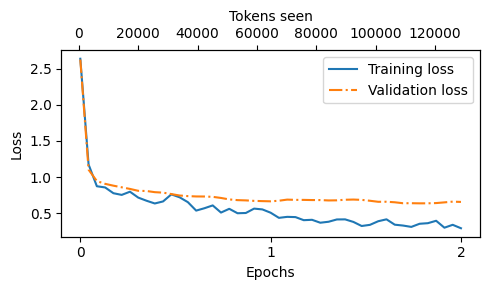

In [83]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [88]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer).to(device), max_new_tokens=256, context_size=BASE_CONFIG['context_length'], eos_id=50256, temperature=0.0)
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("### Response:","").strip()
    test_data[i]["model_response"] = response_text

# with open("instruction-data-with-response.json", "w") as file:
#     json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:09<00:00,  1.58it/s]


In [89]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a bullet.'}

In [90]:
import urllib.request

def query_model(prompt, model="llama3:8b", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages":[
            {"role":"user", "content": prompt}
        ],
        "options":{
            "seed":123,
            "temperature":0,
            "num_ctx": 2048
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

In [91]:
def generate_model_scores(test_data, json_key, model="llama3:8b"):
    scores = []
    for entry in test_data:
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`,"
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score:{score}")
            continue
    return scores

In [93]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores:{len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Number of scores:110 of 110
Average score: 52.38

